In [1]:
### Import Dependencies
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

### Set Display Options
from IPython.display import Image
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth",0)

In [2]:
### Read Diabetes Data (ETL notebook csv export)
diabetes_race = pd.read_csv("Resources/diabetes_strat_race.csv")
diabetes_race.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,readmit,readmit_<30_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other/Unknown,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),weight_Unknown,weight_[0-25),weight_[100-125),weight_[125-150),weight_[175-200),weight_[50-75),weight_[75-100),admission_type_id_Elective,admission_type_id_Emergency,admission_type_id_NULL,admission_type_id_Newborn,admission_type_id_Not Available,admission_type_id_Not Mapped,admission_type_id_Trauma Center,admission_type_id_Urgent,discharge_disposition_id_Discharged to home,discharge_disposition_id_Discharged/transferred to ICF,discharge_disposition_id_Discharged/transferred to SNF,discharge_disposition_id_Discharged/transferred to a long term care hospital.,discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital.,discharge_disposition_id_Discharged/transferred to another short term hospital,discharge_disposition_id_Discharged/transferred to another type of inpatient care institution,discharge_disposition_id_Discharged/transferred to home under care of Home IV provider,discharge_disposition_id_Discharged/transferred to home with home health service,discharge_disposition_id_Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital,discharge_disposition_id_Discharged/transferred/referred to this institution for outpatient services,discharge_disposition_id_Expired,"discharge_disposition_id_Expired at home. Medicaid only, hospice.",discharge_disposition_id_Hospice / home,discharge_disposition_id_Hospice / medical facility,discharge_disposition_id_Left AMA,discharge_disposition_id_NULL,discharge_disposition_id_Neonate discharged to another hospital for neonatal aftercare,admission_source_id_Clinic Referral,admission_source_id_Emergency Room,admission_source_id_HMO Referral,admission_source_id_NULL,admission_source_id_Not Available,admission_source_id_Not Mapped,admission_source_id_Physician Referral,admission_source_id_Transfer from a Skilled Nursing Facility (SNF),admission_source_id_Transfer from a hospital,admission_source_id_Transfer from another health care facility,medical_specialty_?,medical_specialty_AllergyandImmunology,medical_specialty_Anesthesiology,medical_specialty_Cardiology,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology,medical_specialty_Hematology/Oncology,medical_specialty_Hospitalist,medical_specialty_InfectiousDiseases,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Osteopath,medical_specialty_Otolaryngology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-Endocrinology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_PhysicianNotFound,medical_specialty_Podiatry,medical_specialty_Psychiatry,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiologist,medical_specialty_Radiology,medical_specialty_Rheumatology,medical_specialty_Surgeon,medical_specialty_Surgery-Cardiovascular,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-Colon&Rectal,medical_specialty_Surgery-General,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,diabetesMed_No,diabetesMed_Ye

In [3]:
diabetes_race.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3180 entries, 0 to 3179
Columns: 121 entries, time_in_hospital to diabetesMed_Yes
dtypes: int64(121)
memory usage: 2.9 MB


In [4]:
### Declare Independent & Dependent Variables
X = diabetes_race.drop(["readmit"], axis=1)

## y-variable - readmit (yes=1)
y = diabetes_race["readmit"].values.reshape(-1, 1).ravel()

print(X.shape, y.shape)

(3180, 120) (3180,)


In [5]:
### Create Train-Test Split of Our Variable Dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=999)

## Modeling
* Two tree models are ran here: Decision Tree & Random Forest

In [6]:
### Create the Decision Tree Classifier & Fit to Our Training Data
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model = decision_tree_model.fit(X_train, y_train)
decision_tree_scores = decision_tree_model.score(X_test, y_test)
print(f"Decision Tree Prediction Accuracy Score: {decision_tree_scores:.4f}")

Decision Tree Prediction Accuracy Score: 0.6503


In [7]:
### Create the Random Forest Classifier & Fit to Our Training Data  
randomf_model = RandomForestClassifier(n_estimators=1000)
randomf_model = randomf_model.fit(X_train, y_train)
randomf_scores = randomf_model.score(X_test, y_test)
print(f"Random Forest Prediction Accuracy Score: {randomf_scores:.4f}")

Random Forest Prediction Accuracy Score: 0.7107


## Feature Importance of Best Model - Random Forest

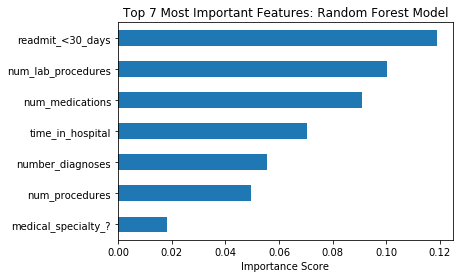

In [8]:
### Calculate Feature Importance Scores & Store in Pandas Series Object
randomf_model_importances_test = pd.Series(randomf_model.feature_importances_, index=X.columns)

### Plot the Top 7 Features
randomf_model_importances_test.nlargest(7).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 7 Most Important Features: Random Forest Model")
plt.xlabel("Importance Score")
plt.show()

## Deep-Dive on Best Model - Random Forest

In [9]:
### Predictions Using Random Forest Model
randomf_model_predict=randomf_model.predict(X_test)

In [10]:
### Cross Validation of Random Forest Results
randomf_model_cv_score = cross_val_score(randomf_model, X, y, cv=10, scoring="roc_auc")

In [11]:
print("*** Confusion Matrix ***")
print(confusion_matrix(y_test, randomf_model_predict))
print("\n")
print("*** Classification Report ***")
print(classification_report(y_test, randomf_model_predict))
print("\n")
print("*** Mean AUC Score ***")
print("Mean AUC Score - Random Forest:", round(randomf_model_cv_score.mean(),4))

*** Confusion Matrix ***
[[419  36]
 [194 146]]


*** Classification Report ***
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       455
           1       0.80      0.43      0.56       340

    accuracy                           0.71       795
   macro avg       0.74      0.68      0.67       795
weighted avg       0.73      0.71      0.69       795



*** Mean AUC Score ***
Mean AUC Score - Random Forest: 0.7186


## Hyperparameter Tuning of Best Model - Random Forest

In [12]:
### Create the GridSearch Object for Random Forest Model
grid_params = { "n_estimators": [1000],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4,5,6,7,8],
    "criterion":["gini", "entropy"]}

grid_randomf = RandomizedSearchCV(randomf_model, grid_params, cv= 5, verbose=2, random_state=999, n_jobs = -1)
randomf_gridsearch = grid_randomf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.8s finished


In [13]:
print("Best Model Score:")
print(randomf_gridsearch.best_score_)
print("\n")
print("Best Model Parameters:")
print(randomf_gridsearch.best_params_)

Best Model Score:
0.69979035639413


Best Model Parameters:
{'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'gini'}


## Apply Hypertuning to Our Best Model

In [14]:
randomf_model_hypertuned = RandomForestClassifier(n_estimators=1000, max_depth=5, max_features="auto", criterion="gini")
randomf_model_hypertuned.fit(X_train,y_train)
randomf_model_hypertuned_predict = randomf_model_hypertuned.predict(X_test)
randomf_model_hypertuned_cv_score = cross_val_score(randomf_model_hypertuned, X, y, cv=10, scoring='roc_auc')
print("Hypertuned test model accuracy is %.4f" % randomf_model_hypertuned.score(X_test, y_test))
print("\n")
print("*** Confusion Matrix ***")
print(confusion_matrix(y_test, randomf_model_hypertuned_predict))
print("\n")
print("*** Classification Report ***")
print(classification_report(y_test, randomf_model_hypertuned_predict))
print("\n")
print("*** Mean AUC Score ***")
print("Mean AUC Score - Random Forest: ", round(randomf_model_hypertuned_cv_score.mean(),4))

Hypertuned test model accuracy is 0.6881


*** Confusion Matrix ***
[[455   0]
 [248  92]]


*** Classification Report ***
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       455
           1       1.00      0.27      0.43       340

    accuracy                           0.69       795
   macro avg       0.82      0.64      0.61       795
weighted avg       0.80      0.69      0.63       795



*** Mean AUC Score ***
Mean AUC Score - Random Forest:  0.7213


## Plotting the AUROC Curve of Our Best Model
* Area Under Receiver Operating Characteristic Curve (aka ROC-AUC)

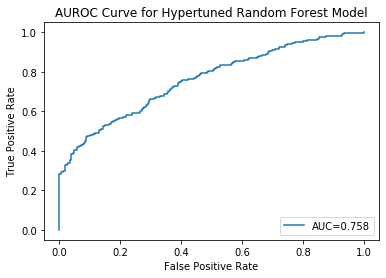

In [15]:
### Plotting the AUROC Curve
y_predict_probabilty = randomf_model_hypertuned.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_predict_probabilty)
auc = round(metrics.roc_auc_score(y_test, y_predict_probabilty), 4)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title("AUROC Curve for Hypertuned Random Forest Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()